### Import libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import zipfile as zf
import warnings

import nltk
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import naive_bayes, svm
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, recall_score, f1_score

sns.set_style('darkgrid')
warnings.filterwarnings("ignore")
#nltk.download('stopwords')

seed = 101

### Read data

In [52]:
zip_file = zf.ZipFile('data.zip') 
df1 = pd.read_csv(zip_file.open('amazon_reviews2.csv'))
df2 = pd.read_csv(zip_file.open('amazon_reviews2.csv'))
df = pd.concat([df1, df2]).reset_index(drop=True)
print("This dataset has {} rows and {} columns.".format(df.shape[0], df.shape[1]))
df.head()

This dataset has 576908 rows and 7 columns.


,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Text
0,B000ER5CTS,A20GGI3B301CKF,0,0,1,1346716800,These biscuts are not safe. My 11 month old w...
1,B000ER5CTS,A37BZQFZ37NODU,0,0,2,1344556800,I gave one of these to my 1-year old who only ...
2,B000ER5CTS,A1ESYGOW49FFJP,0,0,1,1343952000,I gave one of these to my 9 month old (with 9 ...
3,B000ER5CTS,AQQ9ZR1U8AZX4,0,0,1,1339459200,A piece of this biscuit broke off and got stuc...
4,B000ER5CTS,A21AJKOR0VX8PF,0,0,1,1338854400,These are the worst teething biscuits that I h...


In [53]:
# Filter out any review with less than 5 helpful or unhelpful votes
df = df[df['HelpfulnessDenominator'] > 5].reset_index(drop=True)

# Creates helpfulness ratio column
smooth_param = 5
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + smooth_param)

# Converts time stamp to date
df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x).strftime("%d-%m-%Y, %H:%M:%S")[:10])

# Creates new column with length of the review
df['text_length'] = df['Text'].apply(lambda x: len(x.split()))

# Creates new column with the total number of reviews of the user
userId_reviews = pd.DataFrame(df['UserId'].value_counts())
df['UserId_reviews'] = df['UserId'].apply(lambda x: userId_reviews._get_value(x, 'UserId'))

# Drop non-used columns
df = df.drop(['ProductId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'UserId'], axis=1)

In [54]:
print("The dataset has {} rows and {} columns.".format(df.shape[0], df.shape[1]))
df.head()

The dataset has 53770 rows and 5 columns.


,Score,Text,HelpfulnessRatio,text_length,UserId_reviews
0,1,"This is only 1.54 in Target, are you kidding m...",0.000000,22,2
1,5,I had heard of ghost chilis for years before f...,0.875000,269,2
2,5,I just got this stuff in the mail for my birth...,0.807692,302,2
3,5,"This stuff is the best. A dot of this stuff, ...",0.791667,66,2
4,5,Brilliant. An amazing deal if you plan on actu...,0.687500,94,2


Wall time: 3min 32s


<AxesSubplot:>

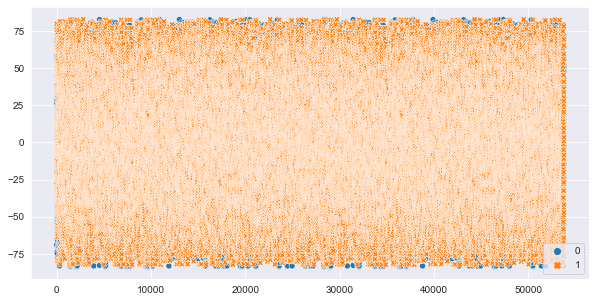

In [42]:
%%time
X_embedded = TSNE(n_components=2).fit_transform(df.drop('Text', axis=1))

plt.figure(figsize=(10,5))
sns.scatterplot(data=X_embedded)
plt.show()

### Target variable

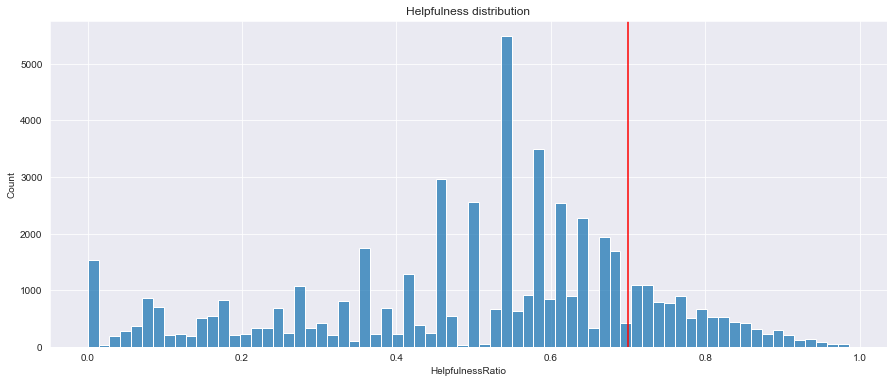

In [55]:
plt.figure(figsize=(15,6))
sns.histplot(x=df['HelpfulnessRatio'], palette='mako').set(title='Helpfulness distribution')
plt.axvline(x=0.7, color='r')
plt.show()

The main objective is not to classify all reviews as unhelful or helpful accordingly, but to be able to correctly identify the most useful ones.<br>
Therefore, we will strictly classify a review as helpful only if its helpfulness ratio is above 0.7

In [56]:
threshold = 0.7 # Top 15th percentile
df['Helpful'] = df['HelpfulnessRatio'].apply(lambda x: 1 if x > threshold else 0)
df.drop(['HelpfulnessRatio'], axis=1, inplace=True)

### Adapt and Balance target variable

9262 helpful reviews and 44508 unhelpful reviews.


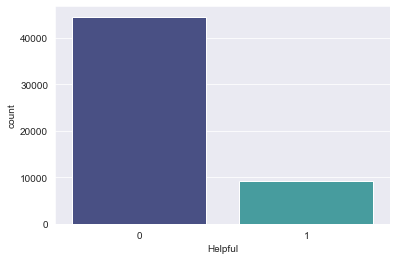

In [57]:
print("{} helpful reviews and {} unhelpful reviews.".format(df['Helpful'].value_counts()[1], df['Helpful'].value_counts()[0]))

sns.countplot(x=df['Helpful'], palette='mako')
plt.show()

When performing oversampling it is important to separate training and testing data before in order to avoid having testing examples in the training set.

In [58]:
test_size = 0.3*len(df)

test_df = df.sample(int(test_size), replace=False, random_state=seed)

# 15k unhelpful reviews will be removed in order to reduce unbalance before upsampling
train_df = df.drop(test_df.index, axis=0)
train_df = train_df.drop(train_df[train_df['Helpful']==0].sample(15000, replace=False, random_state=None).index, axis=0)

test_df.reset_index(inplace=True, drop=True)

In [59]:
helpful_df, unhelpful_df = train_df[train_df['Helpful'] == 1], train_df[train_df['Helpful'] == 0]

if len(helpful_df) > len(unhelpful_df):
    unhelpful_upsampled = resample(unhelpful_df, replace=True, n_samples=len(helpful_df), random_state=seed)
    train_df = pd.concat([helpful_df, unhelpful_upsampled]).reset_index(drop=True)
    
else: 
    helpful_upsampled = resample(helpful_df, replace=True, n_samples=len(unhelpful_df), random_state=seed)
    train_df = pd.concat([unhelpful_df, helpful_upsampled]).reset_index(drop=True)

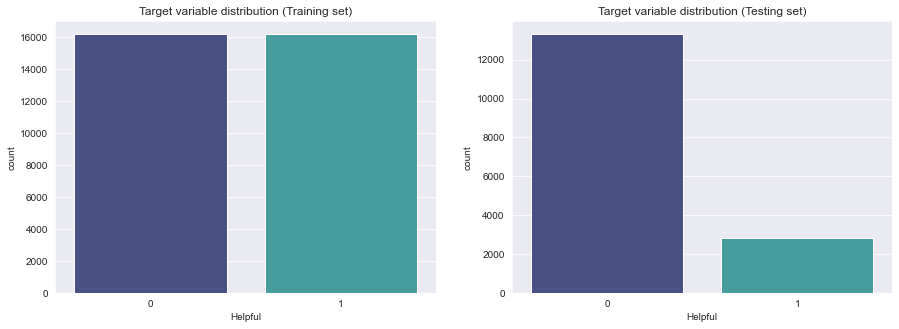

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(ax=axes[0], x=train_df['Helpful'], palette='mako')
axes[0].set_title("Target variable distribution (Training set)")
sns.countplot(ax=axes[1], x=test_df['Helpful'], palette='mako')
axes[1].set_title("Target variable distribution (Testing set)")
plt.show()

### Preprocessing

In [61]:
def preprocessing(df):

    # Remove page breaks
    df['Text'] = df['Text'].str.replace(r'br', ' ', regex=True)

    # Replace URLs with 'webaddress'
    df['Text'] = df['Text'].str.replace(r'http\S+', 'webaddress', regex=True)

    # Remove punctuation
    df['Text'] = df['Text'].str.replace(r'[^\w\d\s]', ' ', regex=True)
    df['Text'] = df['Text'].str.replace(r'_', ' ', regex=True)

    # Replace numbers with 'numbr'
    df['Text'] = df['Text'].str.replace(r'\d+(\.\d+)?', ' ', regex=True)

    # Replace whitespace between terms with a single space
    df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True)

    # Remove leading and trailing whitespace
    df['Text'] = df['Text'].str.replace(r'^\s+|\s+?$', '', regex=True)

    #All words to lowercase
    df['Text'] = df['Text'].str.lower()

    # remove stop words from text messages
    stop_words = set(stopwords.words('english')) - set(['no', 'not'])
    df['Text'] = df['Text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

    # Remove word stems using a Porter stemmer
    ps = PorterStemmer()
    df['Text'] = df['Text'].apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))
    
    return df

In [62]:
%%time
processed_train_df = preprocessing(train_df)
processed_test_df = preprocessing(test_df)

Wall time: 53.1 s


### Create dataset

##### Tf-idf

In [63]:
%%time
temp_X = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, min_df=0.01).fit(processed_train_df['Text'])
X = temp_X.transform(processed_train_df['Text'])
X2 = temp_X.transform(processed_test_df['Text'])

# Every row represents a review and each value in a column is the relative importance of that word in the review.
tfidf_train = pd.DataFrame(X.toarray(), columns=temp_X.get_feature_names())
tfidf_test = pd.DataFrame(X2.toarray(), columns=temp_X.get_feature_names())
tfidf_train.head() 

Wall time: 7.09 s


,abl,absolut,accord,acid,across,activ,actual,ad,add,addict,...,wrong,ye,year,year ago,year old,yeast,yellow,yet,yogurt,yummi
0,0.0,0.200435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Add other features

In [64]:
full_train_df = pd.concat([tfidf_train, train_df.drop('Text', axis=1)], axis=1)
full_test_df = pd.concat([tfidf_test, test_df.drop('Text', axis=1).reset_index(drop=True)], axis=1)
full_train_df.head()

,abl,absolut,accord,acid,across,activ,actual,ad,add,addict,...,year old,yeast,yellow,yet,yogurt,yummi,Score,text_length,UserId_reviews,Helpful
0,0.0,0.200435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,66,2,0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,63,2,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,178,4,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,29,6,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,39,6,0


##### Feature engineering (cluster reviews)

In [65]:
temp_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
preprocessed_text = pd.concat([processed_train_df['Text'], processed_test_df['Text']], axis=0)
temp_X = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=0.1).fit(preprocessed_text)
X = temp_X.transform(preprocessed_text)

temp_tfidf = pd.DataFrame(X.toarray(), columns=temp_X.get_feature_names())

cluster_input = pd.concat([temp_tfidf, temp_df.drop('Text', axis=1)], axis=1).drop('Helpful', axis=1)

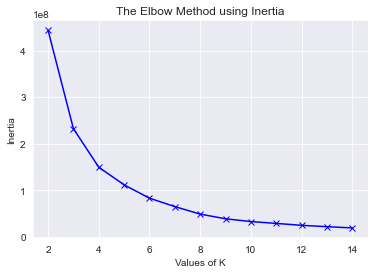

In [22]:
inertias, K = [], range(2, 15)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(cluster_input)
    inertias.append(kmeanModel.inertia_)
    
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

The best number of clusters according to the Elbow plot appears to be 4.

In [66]:
kmeanModel = KMeans(n_clusters=4).fit(cluster_input)

full_train_df['cluster'] = kmeanModel.labels_[:len(full_train_df)]
full_test_df['cluster'] = kmeanModel.labels_[len(full_train_df):]

In [67]:
full_train_df = pd.concat([full_train_df.drop('cluster', axis=1), 
                           pd.get_dummies(full_train_df['cluster'], drop_first=True, prefix="cluster")], axis=1)
full_test_df = pd.concat([full_test_df.drop('cluster', axis=1), 
                          pd.get_dummies(full_test_df['cluster'], drop_first=True, prefix="cluster")], axis=1)

##### Normalize

In [68]:
scaler = StandardScaler()
full_train_df[['Score', 'text_length', 'UserId_reviews']] = scaler.fit_transform(full_train_df[['Score', 'text_length', 'UserId_reviews']])
full_test_df[['Score', 'text_length', 'UserId_reviews']] = scaler.transform(full_test_df[['Score', 'text_length', 'UserId_reviews']])
full_train_df.head()

,abl,absolut,accord,acid,across,activ,actual,ad,add,addict,...,yet,yogurt,yummi,Score,text_length,UserId_reviews,Helpful,cluster_1,cluster_2,cluster_3
0,0.0,0.200435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.740201,-0.488489,-0.377539,0,0,0,1
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.740201,-0.508462,-0.377539,0,0,0,1
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.746419,0.257170,-0.223407,0,0,0,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.740201,-0.734823,-0.069275,0,0,0,1
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.740201,-0.668246,-0.069275,0,0,0,1


##### Convert to sparse matrix

In [76]:
sparse_train = csr_matrix(full_train_df.drop('Helpful', axis=1).values)
sparse_test = csr_matrix(full_test_df.drop('Helpful', axis=1).values)

print("After making our training dataframe sparse we went from {} observations to {} observations".format(full_train_df.shape[0] * full_train_df.shape[1], len(sparse_train.data)))
print("After making our testing dataframe sparse we went from {} observations to {} observations".format(full_test_df.shape[0] * full_test_df.shape[1], len(sparse_test.data)))

After making our training dataframe sparse we went from 35376038 observations to 1428988 observations
After making our testing dataframe sparse we went from 17631183 observations to 628208 observations


### Model

In [77]:
X_train, y_train = sparse_train, full_train_df['Helpful']
X_test, y_test = sparse_test, full_test_df['Helpful']

In [ ]:
%%time
clf_list = [LogisticRegression(random_state = seed), RandomForestClassifier(random_state = seed),
            AdaBoostClassifier(random_state = seed), DecisionTreeClassifier(random_state = seed)]

recall_scores, F1_scores = [], []
for clf in clf_list:
    model = clf.fit(X_train, y_train)
    
    recall_scores.append(recall_score(y_test, clf.predict(X_test)))
    F1_scores.append(f1_score(y_test, clf.predict(X_test)))

LogisticRegression has a recall of 68.92% and an F1-score of 45.74%
RandomForestClassifier has a recall of 78.51% and an F1-score of 84.73%
AdaBoostClassifier has a recall of 65.04% and an F1-score of 42.55%
DecisionTreeClassifier has a recall of 84.5% and an F1-score of 72.02%


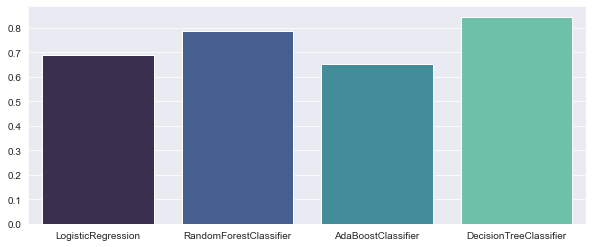

In [51]:
models = ['LogisticRegression', 'RandomForestClassifier', 'AdaBoostClassifier', 'DecisionTreeClassifier']
for model, recall, f1 in zip(models, recall_scores, F1_scores):
    print('{} has a recall of {}% and an F1-score of {}%'.format(model, round(100*recall, 2), round(100*f1, 2)))

plt.figure(figsize=(10, 4))
sns.barplot(x=models, y=recall_scores, palette='mako')
plt.show()

In [52]:
%%time
gs = GridSearchCV(
    cv=KFold(n_splits=5, shuffle=True),
    estimator=RandomForestClassifier(),
    param_grid={'max_depth': [20, 50, 100], 'class_weight': ['balanced', {0:1,1:5}]},
    scoring='f1'
)

gs.fit(X_train, y_train)
print (gs.best_estimator_)

RandomForestClassifier(class_weight='balanced', max_depth=100)
Wall time: 8min 27s


In [86]:
tree_clf = RandomForestClassifier(max_depth=100).fit(X_train, y_train)

print("Training accuracy: {}%\nTesting accuracy: {}%\nRecall: {}%\nF1 Score: {}%"
      .format(round(tree_clf.score(X_train, y_train)*100, 3), round(tree_clf.score(X_test, y_test)*100, 3), 
              round(recall_score(y_test, tree_clf.predict(X_test))*100, 3), 
              round(f1_score(y_test, tree_clf.predict(X_test))*100, 3)))

Training accuracy: 99.824%
Testing accuracy: 95.103%
Recall: 79.081%
F1 Score: 84.889%


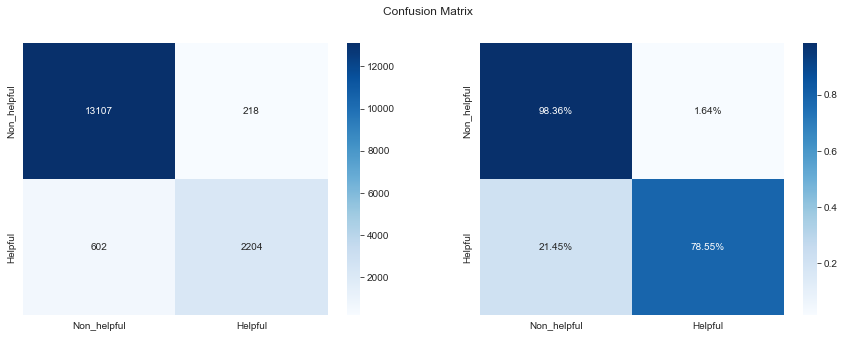

In [81]:
confusion = confusion_matrix(y_test, tree_clf.predict(X_test))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Confusion Matrix')
categories = ['Non_helpful', 'Helpful']
sns.heatmap(ax=axes[0], data=confusion, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
sns.heatmap(ax=axes[1], data=confusion / np.sum(confusion, axis=1).reshape(-1,1), annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.show()

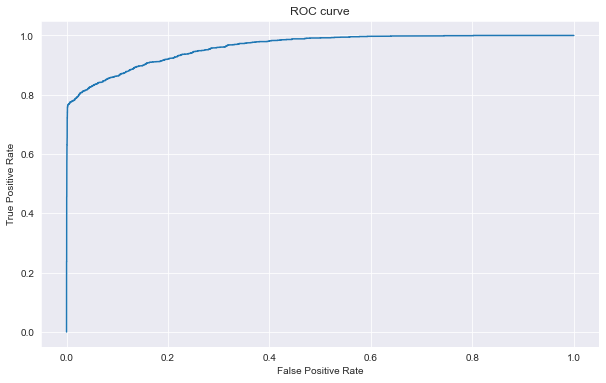

In [82]:
plt.figure(figsize=(10,6))
fpr, tpr, _ = roc_curve(y_test, tree_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Post model analysis

In [83]:
pd.set_option('display.max_colwidth', None)

In [98]:
%%time
true_values = list(y_test)
pred_values = tree_clf.predict(X_test)

df_check = pd.DataFrame(columns=['text', 'true label', 'pred label'])
for i, j in zip(y_test.index, range(len(y_test))):
    df_check.loc[len(df_check.index)] = [df.loc[i, 'Text'], true_values[j], pred_values[j]] 

Wall time: 23.8 s


In [100]:
df_check[df_check['true label'] != df_check['pred label']].head()

,text,true label,pred label
79,This berry is gross! It even made me sick! I would not advise any one to buy this item.,1,0
80,"Well, Amazon asked for a review of the gogi berries and what can you say? They are gogi berries. The product arrived in a timely manner and in perfect condition. They taste the same as other gogi berries that I have had and since gogi berries have a reputation for making you happy, perhaps they are just as effective, too. Not a bad deal for the money.",1,0
205,"These are soooooo delicious, I don't know where the person that gave these 1 star got them from but I have never had a bad one. They are super moist and the cream is amazing!<br />If you love oreo's you will love these even more.<br />Warning: Once you try them you are guaranteed to be hooked!",1,0
218,"Santa Fe Bean Company:<br /><br />-- Mild cereal flavor, similar to corn flakes (which I prefer). Moderate sodium taste; in fact, this brand tastes as though it has more sodium, contrary to the nutrition labels.<br /><br />-- Some clumping of dry bean flakes. Rehydrate slightly less rapidly, although no problem. Two halves of an unflaked bean found, after the contents of ~5 packages consumed; no damage to my teeth.<br /><br />-- Lower price per ounce.<br /><br />-- Convenient bag, durable and resealable. No individual box to discard.<br /><br /> Taste Adventure:<br /><br />-- Mild bean flavor. No significant sodium taste, although the nutrition labels indicate this brand has more sodium.<br /><br />-- No clumping of dry bean flakes. Rehydrate quite rapidly. No unflaked beans found, after the contents of >60 packages consumed.<br /><br />-- Higher price per ounce.<br /><br />-- Packaging less convenient. A little bit of bean powder sometimes found in individual cardboard box. Plastic bag not designed to be resealed.",0,1
230,"No corn<br />No wheat<br />No artificial colors, flavors, or by-products<br />Made in the USA<br /><br />I've always liked the Zukes offerings and so do my pooches. When I noticed they made a product called turkey 'n taterz, I had to buy it so my girls could try it. Evie the bichon loved them right away and gobbled several of the flat-bottomed, oval treats in short order. Ever the fussy one, Piper the shih tzu had to be cajoled and had to see if Evie liked them. After her first taste, Piper was a convert soon begging for more.<br /><br />The crunchy treats come in a convenient small size, but have an indentation in the middle so that one can more readily break them in two for dainty dogs who like small bites. (Namely Piper the shih tzu)<br /><br />Made with USDA turkey and fresh potatoes, these wholesome treats are bound to get the attention of spudophiles everywhere. Give them as treats or rewards or sprinkle them on the dinner plate for those reluctant fussy eaters. (See Piper above)",0,1


In [37]:
# Top features
X_train.columns[np.argsort(tree_clf.feature_importances_)[len(tree_clf.feature_importances_)-50:]]

Index(['favorit', 'bag', 'even', 'littl', 'day', 'add', 'look', 'year', 'go',
       'made', 'better', 'recommend', 'food', 'much', 'found', 'order', 'want',
       'realli', 'mani', 'coffe', 'amazon', 'price', 'find', 'well', 'eat',
       'buy', 'also', 'cup', 'time', 'flavor', 'would', 'keurig', 'make',
       'best', 'great', 'love', 'one', 'good', 'no', 'product', 'tast', 'like',
       'tri', 'get', 'not', 'use', 'cluster_3', 'UserId_reviews',
       'text_length', 'Score'],
      dtype='object')

### To do 
* Run Random Forest with increasing amount of features and plot the accuracy (to see when it plateaus)
* Use dictionary with predefined word values (sentiment dictionary methods for product reviews)
* Add a validation dataset